In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import gdal
import nivapy3 as nivapy
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Machine learning for image classification part 2: refining the classification scheme

Following the preliminary analysis [here](https://github.com/JamesSample/image_drone/blob/master/notebooks/drone_ml_image_class.ipynb), Kasper has defined a more detailed classification scheme including other substrates of interest (see e-mail received 14.09.2018 at 13.58). Janne has then digitised three of the larger mosaiced images using Kasper's new categories. The digitised data from Janne is here:

    ...\Drone_Image_Machine_Learning\data_package_janne_digitised
    
This notebook repeats much of the analysis from the exploratory workflow, but this time using the new categories and the larger image mosaics.

## 1. Classification scheme

The code below reads Kasper's new classification scheme from an Excel file (including some rough suggested colours for subsequent visualisation).

In [2]:
# Read substrate code domains
xl_path = r'/home/jovyan/shared/dronning_2019/data_package_janne_digitised/substrate_coded_domains.xlsx'
sub_df = pd.read_excel(xl_path, sheet_name='Sheet1')
sub_df

,code,substrate,colour
0,-1,Other/Unknown,white
1,0,No data,white
2,1,Eelgrass (dense),green
3,2,Eelgrass (scattered),lightgreen
4,3,Brown algae,tan
5,4,Green algae,lime
6,5,Red algae,red
7,6,Filamentous brown,saddlebrown
8,7,Sagrassum/Halidrys/Ascophyllum,turquoise
9,8,Mixed seaweed,pink


## 2. Rasterise vector training data

The digitised data from Janne is stored in a File Geodatabase here:

    ...\data_package_janne_digitised\vector\drone_training_data.gdb
    
I have clipped the feature classes to the bounding boxes of the underlying GeoTiffs, and then exported each one as a shapefile. The code below converts these shapefiles to rasters with the same cell size and extent as the parent GeoTiffs.

In [3]:
# Image names
fnames = ['1_1_3', '1_2_2', '1_2_4']

# Loop over shapefiles
for name in fnames:
    # Build path to shp
    shp_path = (r'/home/jovyan/shared/dronning_2019/data_package_janne_digitised/vector/'
                r'olberg_group_%s.shp' % name)
    
    # Build path to parent .tif
    snap_tif = (r'/home/jovyan/shared/dronning_2019/data_package_janne_digitised/raster/'
                r'Olberg_RBG1og2_45_v3224m_transparent_mosaic_group%s.tif' % name)

    # Build path to output tiff
    tif_path = (r'/home/jovyan/shared/dronning_2019/data_package_janne_digitised/raster/training_data/'
                r'olberg_group_%s.tif' % name)
    
    # Rasterise
    nivapy.spatial.shp_to_ras(shp_path, tif_path, snap_tif, 'substrate', 
                              -1, gdal.GDT_Int16)

## 3. Visualise training data

The plots below show the three mosaiced drone images alongside the rasterised versions of Janne's training dataset.

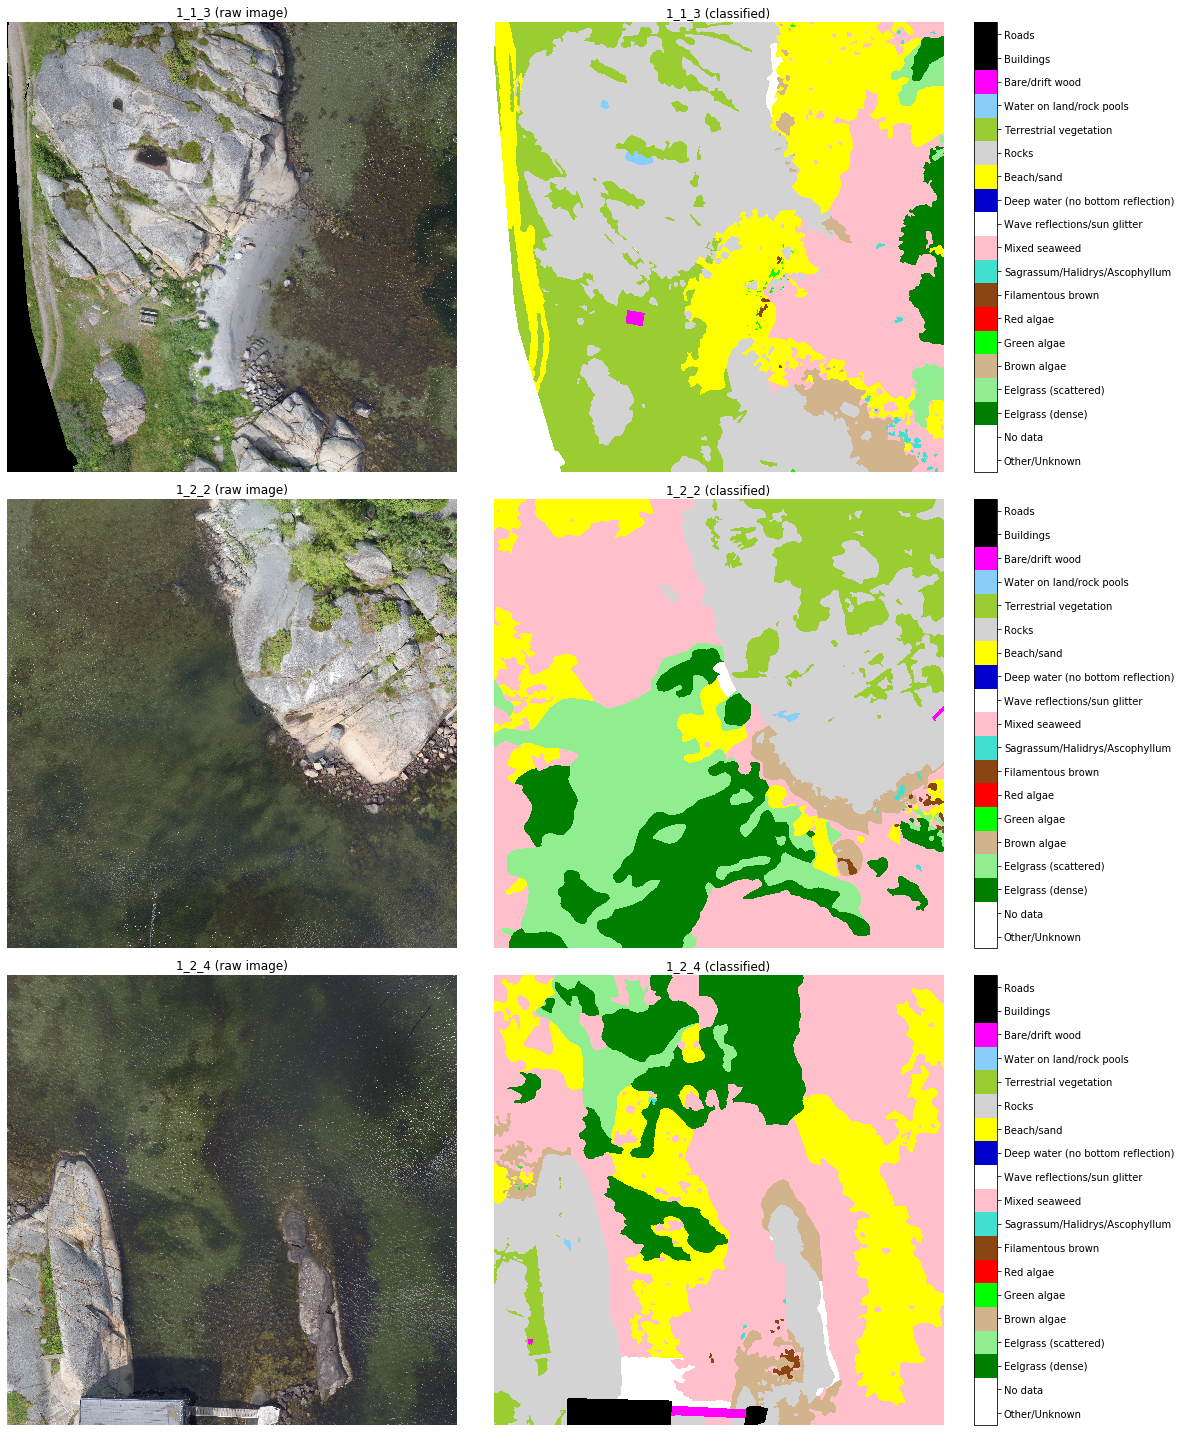

In [4]:
# Setup plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,20))

# Define colours for manual classes
cmap = colors.ListedColormap(list(sub_df['colour']))
bounds = np.arange(-1.5, 18.5)
norm = colors.BoundaryNorm(bounds, cmap.N)

# Loop over data
for idx, name in enumerate(fnames):
    # Paths to images
    raw_path = (r'/home/jovyan/shared/dronning_2019/data_package_janne_digitised/raster/'
                r'Olberg_RBG1og2_45_v3224m_transparent_mosaic_group%s.tif' % name)
    
    man_path = (r'/home/jovyan/shared/dronning_2019/data_package_janne_digitised/raster/training_data/'
                r'olberg_group_%s.tif' % name)
    
    # Read raw bands to arrays
    band1, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=1)
    band2, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=2)
    band3, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=3)
    raw_img = np.dstack((band1, band2, band3))
    
    # Read manually classified data (1 band only)
    man_img, ndv, epsg, extent = nivapy.spatial.read_raster(man_path, band_no=1)
    
    # Plot
    # Raw image
    axes[idx, 0].imshow(raw_img)
    axes[idx, 0].set_title('%s (raw image)' % name, fontsize=12)
    
    # Manually classified
    img = axes[idx, 1].imshow(man_img, cmap=cmap, norm=norm)
    axes[idx, 1].set_title('%s (classified)' % name, fontsize=12)
    
    # Turn off axes
    axes[idx, 0].axis('off')
    axes[idx, 1].axis('off')
    
    # Colourbar for manual dataset
    cb = plt.colorbar(img, ax=axes[idx, 1])    
    cb.set_ticks(list(sub_df['code']))
    cb.set_ticklabels(list(sub_df['substrate']))
    
plt.tight_layout()

## 4. Train classifier

Each image mosaic is 5000 x 5000 pixels, so we have 25 megapixels per image *band* (i.e. 75 megapixels per image). From a machine learning perspective, this will equate to 25 million "samples" per image, each with three "features". Note that this isn't actually much greater than the individual "raw" images, which were roughly 4600 x 3500 pixels each - see Section 3 of the [exploratory notebook](https://github.com/JamesSample/image_drone/blob/master/notebooks/drone_ml_image_class.ipynb) for details. This is because each separate image has a large overlap with its neighbours, so even though the mosaics comprise many different photographs, the final resampled mosaic is not much bigger than a single image. For this reason, **we might expect the performance of the algorithm to decrease substantially in this test**, because the amount of training data (i.e. pixels) has not increased much, but the number of categories to identify has more than doubled.

For this test, I will use the data from images `'1_1_3'` and `'1_2_2'` to train the algorithm, then evaluate it by applying the trained model to image `'1_2_4'`. This will be quite a challenging test, because image `'1_2_4'` contains features such as buildings, boardwalks and shadows that are not well represented in the training data.

The total number of samples in the training dataset should be just under 50 million, becasue I will remove the "No Data"/"Other" pixels from consideration (e.g. the black border in the lower left part of image `'1_1_3'`.

### 4.1. Extract training data

In [5]:
# Containers for data
y_list = []
r_list = []
g_list = []
b_list = []

# Loop over data for images 1 and 2
for name in fnames[:2]:
    # Paths to images
    raw_path = (r'/home/jovyan/shared/dronning_2019/data_package_janne_digitised/raster/'
                r'Olberg_RBG1og2_45_v3224m_transparent_mosaic_group%s.tif' % name)
    
    man_path = (r'/home/jovyan/shared/dronning_2019/data_package_janne_digitised/raster/training_data/'
                r'olberg_group_%s.tif' % name)
    
    # Read raw bands to arrays
    band1, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=1)
    band2, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=2)
    band3, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=3)
    
    # Read manually classified data (1 band only)
    man_img, ndv, epsg, extent = nivapy.spatial.read_raster(man_path, band_no=1)
       
    # Flatten to 1D and append
    y_list.append(man_img.flatten())
    r_list.append(band1.flatten())
    g_list.append(band2.flatten())
    b_list.append(band3.flatten())
    
# Concatenate to single dataset
y = np.concatenate(y_list)
r = np.concatenate(r_list)
g = np.concatenate(g_list)
b = np.concatenate(b_list)

# Build df
df = pd.DataFrame({'y':y,
                   'r':r,
                   'g':g,
                   'b':b})

# Some values are "No data" due to edge effects. Remove these
df = df.query('y > 0')

print('Number of training samples: %.1f million.' % (len(df)/1E6))

Number of training samples: 48.7 million.


### 4.2. Train random forest

The code below uses the same approach as in the exploratory notebook.

**Note:** The default random forest in scikit-learn has just 10 trees, which is a very small "forest". It would be better to increase this number to e.g. 100 (`'n_estimators=100'` in the code below), but this takes a long time to process. When I return after Christmas, I'll run the algorithm overnight with 100 tress to see if it significantly improves performance. If it does, it might be worth considering switching to e.g. TensorFlow for the ML component, as this should be faster than scikit-learn.

In [6]:
%%time

# Fit classifier to training data
classifier = RandomForestClassifier(n_jobs=-1, n_estimators=10)
classifier.fit(df[['r', 'g', 'b']], 
               df['y'])

CPU times: user 16min 36s, sys: 39.2 s, total: 17min 15s
Wall time: 3min 5s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

## 5. Predict test image

We can now use the trained model to predict pixel categories for image `'1_2_4'`.

### 5.1. Make predictions

In [7]:
# Get image name
name = fnames[-1]

# Paths to images
raw_path = (r'/home/jovyan/shared/dronning_2019/data_package_janne_digitised/raster/'
            r'Olberg_RBG1og2_45_v3224m_transparent_mosaic_group%s.tif' % name)

man_path = (r'/home/jovyan/shared/dronning_2019/data_package_janne_digitised/raster/training_data/'
            r'olberg_group_%s.tif' % name)

# Read raw bands to arrays
band1, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=1)
band2, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=2)
band3, ndv, epsg, extent = nivapy.spatial.read_raster(raw_path, band_no=3)

# Read manually classified data (1 band only)
man_img, ndv, epsg, extent = nivapy.spatial.read_raster(man_path, band_no=1)   
    
# Build df
df = pd.DataFrame({'r':band1.flatten(),
                   'g':band2.flatten(),
                   'b':band3.flatten()})

# Predict classes for new image
pred_img = classifier.predict(df[['r', 'g', 'b']]).reshape(man_img.shape)

### 5.2. Evaluate predictions

The code below computes some simple diagnotic and performance metrics for the fitted model (compared to Janne's manual classification for the test image, which is assumed to represent the "truth").

In [8]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap='coolwarm'):
    """ Plots the confusion matrix.
    
        Normalization can be applied by setting `normalize=True`.
        
        From:
        
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import itertools
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.6)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, horizontalalignment='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classification report:
                                precision    recall  f1-score   support

                 Other/Unknown       0.00      0.00      0.00    363236
              Eelgrass (dense)       0.46      0.51      0.48   3321653
          Eelgrass (scattered)       0.14      0.63      0.22    920799
                   Brown algae       0.15      0.10      0.12    915330
                   Green algae       0.00      0.00      0.00      3582
             Filamentous brown       0.01      0.00      0.00     46736
Sagrassum/Halidrys/Ascophyllum       0.00      0.01      0.01      7568
                 Mixed seaweed       0.77      0.58      0.66   9713148
  Wave reflections/sun glitter       0.00      0.00      0.00     67244
                    Beach/sand       0.69      0.32      0.44   4917071
                         Rocks       0.61      0.93      0.73   3882047
        Terrestrial vegetation       0.44      0.83      0.58    368686
      Water on land/rock pools       0.0

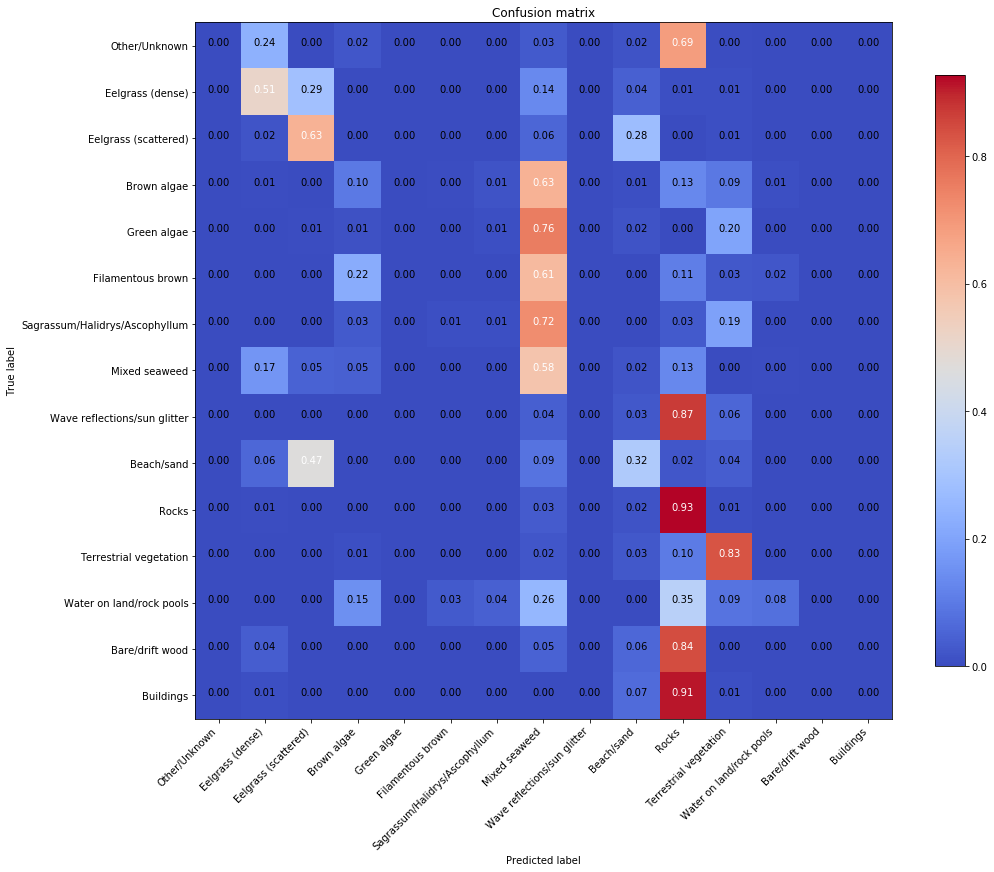

In [9]:
# The training dataset only includes some of the possible labels
# Extract these for now
class_labels = [-1, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16]
target_names = list(sub_df.query('code in @class_labels')['substrate'])

print("Classification report:\n%s" %
      metrics.classification_report(man_img.flatten(), 
                                    pred_img.flatten(), 
                                    labels=class_labels, 
                                    target_names=target_names))

print("Classification accuracy: %f" %
      metrics.accuracy_score(man_img.flatten(), pred_img.flatten()))

# Congusion matrix    
fig = plt.figure(figsize=(15,15))
fig.add_subplot(111)
cm = metrics.confusion_matrix(man_img.flatten(), pred_img.flatten())
plot_confusion_matrix(cm, normalize=True, classes=target_names)

The model's performance is significantly worse than in the exploratory notebook, although this is not surprising since the amount of training information has not increased much, whereas the level of detail demanded by the classification scheme is much higher than before. The new classification scheme also includes several substrates that are very similar in appearance. For example, the distinction between `'Eelgrass (scattered)'` and `'Beach/sand'` is often subtle, and not obvious even to a human eye. 

In general, the algorithm performs pretty well for eel grass (both dense and scattered), mixed seaweed, rocks and terrestrial vegetation. The majority of mis-classifications are not a major problem (e.g. buildings are consistently mis-classified as rocks, which probably doesn't matter too much), but some issues are more serious: brown & green algaes, fillamentous brown and Sagrassum/Halidrys/Ascophyllum are all frequently classified as mixed seaweed; beach/sand is also commonly confused with scattered eelgrass. Some of these problems are understandable. For example, based on the raw test image (see plot below), the distinction between scattered eelgrass (pale green) and beach/sand (yellow) is not especially obvious to my eye.

### 5.3. Show classified image

The top plot below shows the original image, the middle plot is Janne's manual classification, and the lower plot is the output from the random forest algorithm.

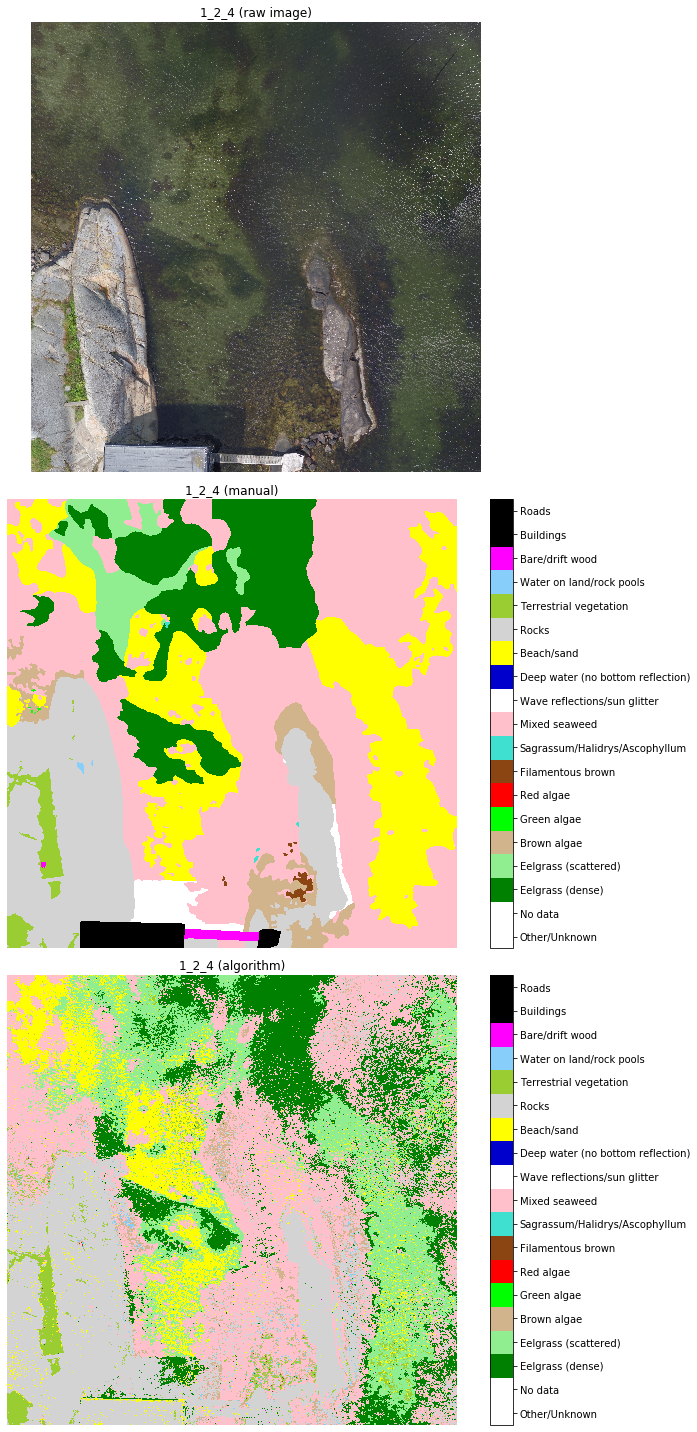

In [10]:
# Setup plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(11,20))
   
# Stack bands
raw_img = np.dstack((band1, band2, band3))

# Raw image
axes[0].imshow(raw_img)
axes[0].set_title('%s (raw image)' % name, fontsize=12)

# Manually classified
mimg = axes[1].imshow(man_img, cmap=cmap, norm=norm)
axes[1].set_title('%s (manual)' % name, fontsize=12)

# Predicted
aimg = axes[2].imshow(pred_img, cmap=cmap, norm=norm)
axes[2].set_title('%s (algorithm)' % name, fontsize=12)

# Turn off axes
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

# Colourbar for manual dataset
mcb = plt.colorbar(mimg, ax=axes[1])    
mcb.set_ticks(list(sub_df['code']))
mcb.set_ticklabels(list(sub_df['substrate']))

# Colourbar for manual dataset
acb = plt.colorbar(aimg, ax=axes[2])    
acb.set_ticks(list(sub_df['code']))
acb.set_ticklabels(list(sub_df['substrate']))
    
plt.tight_layout()

The predicted map is actually bettter than expected from the confusion matrix and performance statistics. The key categories have been correctly identified, and most of the mis-classifications are between similar/borderline groups (e.g. dense versus scattered eelgrass). If we were primarily interested in mapping relative substrate areas, this simple algorithm would actually work OK. The most obvious error is that a large area of beach/sand along the right-side of the image has been incorrectly classified as scattered eelgrass. However, looking at the raw image (top plot) I think this confusion is understandable, as the distinction between the two zones is quite subtle.

## 6. Conclusion

I don't think there is enough information in the basic (R, G, B) mosaics to robustly distinguish the 17 classes in the classification scheme used here. Manually classifying more images to create a bigger training dataset would help, but probably not enough to produce something robust for practical use. The main options for further development are:
 
 1. Simplify the classification scheme to something more like the original that was used in the [preliminary analysis](https://github.com/JamesSample/image_drone/blob/master/notebooks/drone_ml_image_class.ipynb) (i.e. about 7 classes overall, with the main focus on distinguishing between eelgrass, seaweed and sandy sediment, which are usually distinctive)
   
 2. Add additional spectral information (i.e. more features)
 
 3. Try other ML algorithms, as well as further tweaking of the current algorithm by e.g. properly tuning the hyperparameters (so far, I've just used rough defaults)
   
I suspect the best way forward is a **combination of all three options**. Firstly, we should simplify the classification scheme a bit; perhaps not right back to the one used in the preliminary analysis, but something intermediate e.g. 10 to 12 classes in total. Secondly, if additional spectral information is available, we should align it with the existing (R, G, B) TIFF images and incorporate it wherever possible. Without this, the algorithm has access to broadly the same information as can be detected by the human eye, and humans are *extremely* good (often too good :-) at pattern recognition. It is therefore unlikely that an ML algorithm will perform better than a human (in terms of accuracy; the algorithm will always be faster), unless additional information is provided. Given that I find it difficult to distinguish between some of the substrate classes in the classification scheme used here, I'm not surprised the algorithm is struggling too. Adding other spectral bands gives the algorithm access to information beyond the visible spectrum, which measn there's a *chance* it will perform better than a human (especially if some of the substrate classes have a strong "response" at non-visible wavelengths). Thirdly, I need to set aside some time for algorithm tuning, modification and cross-validation. ML is a very broad subject, and using the default options "off-the-shelf" is almost never a good idea. Finally - as always - you can (almost) never have enough training data, so digitising more images would be worthwhile if we can find the time and resources to do it.